Read data and tokenize

In [1]:
import json
with open("sikm_groupsio-l.json", 'rb') as f:
    bstream = f.read()
txt = bstream.decode("utf-8")

import re
txt_proper2 = re.split('\r\n',txt)


min_length_content = 10;

# fix json non standard format https://www.json.org/json-en.html
posts_list = []
for i, ln in enumerate(txt_proper2):
    if len(ln) > 0:
        to_append = json.loads(ln)
        if len(to_append["content"]) > min_length_content:
            # forget about comment at this moment
            to_append_content = to_append['content']
            posts_list.append(to_append_content)

                   
                   
import nltk
from nltk.corpus import stopwords




def is_valid_posts(p):
    if len(nltk.tokenize(p)) < min_length_content :
        return False
    
    return True

stopwords_list =  stopwords.words("english")

posts_list_tokenized = [nltk.tokenize.word_tokenize(p) for p in posts_list]

posts_list_tokenized_stop_removed = []

#remove stopword and punctuation


In [2]:

post_corpus=set()
from collections import Counter
post_corpus_counter = Counter()
ndoc_counter = Counter()
def filter_word(list_token):
    return [word.lower() for word in list_token if word.isalpha() and  word not in stopwords_list]
    
doc_req_counter = Counter()
gram = 1
if gram == 1:
    for p in posts_list_tokenized:
        p2 = filter_word(p)
        if len(p2) >= min_length_content:
            posts_list_tokenized_stop_removed.append(p2 )
    
    
    def to_vector(sortedkeys):
        pass
    
    for p in posts_list_tokenized_stop_removed:
        post_corpus_counter+=  Counter(p)
        word_set = set()
        for word in p:
            word_set.add(word)
        for word in word_set:
            doc_req_counter[word] += 1


elif gram == 2:
# digram
    raise(NotImplementedError("work in progress"))

    for p in posts_list_tokenized[:10]:
        
        for i_digram in range(len(p)-1):
            # simple rules, both not stop words
            digram = tuple(p[i_digram:i_digram+2])
            if len(filter_word(digram)) > 0:
                post_corpus.add(digram)
                post_corpus_counter[digram]+=1
                pass
            
            pass



term_freq_dict = {k: v for (k, v) in post_corpus_counter.items()}


In [3]:
#%% sort keys according to alphabetical order
sorted_keys = sorted(term_freq_dict.keys())
import numpy as np
term_freq_vector_np = np.zeros([1, len(sorted_keys)])
for i, k in enumerate(sorted_keys):
    v = term_freq_dict[k]
    term_freq_vector_np[0][i] = v

#%% calculat IDF   http://www.tfidf.com/
idf_np = np.zeros([1, len(sorted_keys)])
n_doc = len(posts_list_tokenized_stop_removed)
for i, key in enumerate(sorted_keys):
    cnt = doc_req_counter[key]
    idf_np[0,i] = np.log(n_doc / cnt)  
    # suppose any high-frequency suppressing function work


In [6]:
#%% vectorising post
l0  = len(posts_list)
l1 = len(posts_list_tokenized)
dl = l0-l1
print(f"before {len(posts_list)}, after {len(posts_list_tokenized)}, removed {dl}")

# helper function to vectorize any post vector given any global corpus
word_2_index = {}
for i , k in enumerate(sorted_keys):
    word_2_index[k] = i

def get_idf(word):
    if word not in word_2_index:
        return -1
    
    return idf_np[0, word_2_index[word]]

tf_idf_np = term_freq_vector_np * idf_np

def to_vector(post, sortedkeys = None):
    from collections import Counter
    
    sglobal = set(sortedkeys)
    spost = set(post)
    if not sglobal >= spost:
        raise Exception("post contains words not in global, not handled yet")
    post_vector_np = np.zeros([1, len(sorted_keys)])
    for word, cnt in dict(Counter(post)).items():
        idx = word_2_index[word]
        post_vector_np[0,idx] = cnt
    return post_vector_np

vectorized_post = []

for i, p in enumerate(posts_list_tokenized_stop_removed[:]):
    if i % 100 == 0:
        print(f"Done {i} posts")
    vectorized_post.append(to_vector(p, sortedkeys = sorted_keys) *
                           tf_idf_np)


before 2300, after 2300, removed 0
Done 0 posts
Done 100 posts
Done 200 posts
Done 300 posts
Done 400 posts
Done 500 posts
Done 600 posts
Done 700 posts
Done 800 posts
Done 900 posts
Done 1000 posts
Done 1100 posts
Done 1200 posts
Done 1300 posts
Done 1400 posts
Done 1500 posts
Done 1600 posts
Done 1700 posts
Done 1800 posts
Done 1900 posts
Done 2000 posts
Done 2100 posts
Done 2200 posts


In [7]:
#%% brute force search

# high dimensional nearest neighbour search brute force first

search_word_list = ["knowledge", "management"]
# uncomment below and pick a post to see if can find itself as a sanity test

# search_word_list = posts_list_tokenized_stop_removed[895]
search_filtered = filter_word(search_word_list)
vectorized_search = to_vector(search_filtered, sortedkeys = sorted_keys)

if len(search_filtered) > 0:
    # simplest case find 1 post only
    max_post = None
    max_similarity = 0
    for post_ID , tgt in enumerate(vectorized_post):
        siamese_cosine = np.sum(vectorized_search * tgt, axis = 1)
        siamese_cosine /= (np.sum(vectorized_search, axis = 1) * 
                           np.sum(tgt, axis = 1) )
        #print(siamese_cosine)
        if siamese_cosine > max_similarity:
            max_similarity, max_post, max_post_ID = siamese_cosine, tgt, post_ID
        #print(posts_list[max_post_ID])
    
else:
    raise ValueError("search keyworkds contain stopwords only")
print(f"Top post: {posts_list[max_post_ID]}")

Top post: Knowledge Management Consultancy - IOM Regional Office for Central America, North America and the Caribbeanhttps://rosanjose.iom.int/SITE/en/vacancy/knowledge-management-consultancy


Knowledge management appearing 2 times in a short reply, as justifiable result

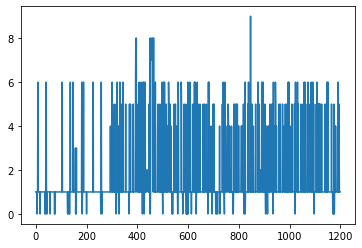

In [8]:
# Group up the posts before search
# brute force done, now do some clustering on topics
""" many to choose from before needing to invent own:
    https://scikit-learn.org/stable/modules/clustering.html
    """

from sklearn.cluster import AgglomerativeClustering, Birch, DBSCAN, KMeans

vectorized_post2 = [v[0,:] for v in vectorized_post]
n_cluster = 10  # currently set just for exploration, no reason why 10
# other choices commented
# myCluster = KMeans(n_clusters = n_cluster).fit(vectorized_post2[:1200])
# myCluster = DBSCAN(n_clusters = n_cluster).fit(vectorized_post2[:1200])
# myCluster = Birch(n_clusters = n_cluster).fit(vectorized_post2[:1200])
myCluster = AgglomerativeClustering(n_clusters = 10).fit(vectorized_post2[:1200])
from matplotlib import pyplot as plt
# take a look at the label distributions
plt.plot(myCluster.labels_)


In [11]:
#%% group posts by labels
from collections import defaultdict
posts_ID_group_by_topic = defaultdict(list)
for i, group_num in enumerate(myCluster.labels_):
    posts_ID_group_by_topic[group_num].append(i)
    
    pass
topic_centroid = np.zeros([n_cluster,len(sorted_keys)])
vectorized_post_np = np.concatenate(vectorized_post, axis = 0)
for label, list_of_post_id in posts_ID_group_by_topic.items():
    topic_posts = vectorized_post_np[list_of_post_id]
    topic_centroid[label] = np.mean(topic_posts, axis = 0)
    pass

def exhaust_nearest_siamese(tgt, lookup):
    tgt_magnitude = np.sqrt(np.sum(tgt**2, axis = 1))
    projection = np.dot(lookup, tgt.transpose())
    magnitude = np.sqrt(np.sum(lookup**2, axis = 1))
    projection_normalised = np.concatenate([projection[i] / (magnitude[i] * tgt_magnitude) for i in range (len(projection))])
    return np.argmax(projection_normalised )

topic = exhaust_nearest_siamese(tgt = vectorized_search,lookup =  topic_centroid)

topic_posts_vectorized = vectorized_post_np[posts_ID_group_by_topic[topic]]
topic_posts = [posts_list[i] for i in posts_ID_group_by_topic[0]]


in_topic_similarity = np.dot(topic_posts_vectorized, vectorized_search.transpose())
tgt_magnitude = np.sqrt(np.sum(vectorized_search**2, axis = 1))
magnitude = np.sqrt(np.sum(topic_posts_vectorized**2, axis = 1))
similarity_normalised = np.concatenate([in_topic_similarity[i] / (magnitude[i] * tgt_magnitude) for i in range (len(in_topic_similarity))])



post_sorted_by_simiarity = np.array(topic_posts)[np.argsort(similarity_normalised, axis = 0)]

sorted by increasing similarity, highest is found at last post in post_sorted_by_simiarity

In [13]:
print(post_sorted_by_simiarity[-1])

"Hello all,I am a new KM practitioner looking to incorporate\xa0Knowledge Management at my company, Apeel Sciences.\xa0 In brief, my company makes edible products from natural plant extracts that allow organic and conventional growers to reduce reliance on pesticides, increase produce quality, and provide superior shelf life.\xa0 Our success thus far has been directly linked to our ability drive innovation from scientific experimentation.\xa0 We recognize that the failure to capture, iterate and expand our current knowledge is essential for our future.\xa0\xa0With this in mind, I am leading the charge into Knowledge Management for our company and will be attending KMWorld 2017 to learn more about the industry, connect with others, and determine what practices can most beneficial\xa0for my company.\xa0Currently, we are planning to roll out a wiki-based knowledge management system and I would love to hear about other people's experiences with this type platform.\xa0 What were some of the

In [15]:
print(post_sorted_by_simiarity[-2])

Hi All,  I wanted to draw from the group well of knowledge with
respect to KCS.  I have been told that
this is the “best in class” for KM for support organizations.
Could you let me know your thoughts on this statement? Are there alternative organizations
to KCS that we should consider?  If you have any other pertinent thoughts on this, I would appreciate
them.  Thank you,
















Chuck


In [18]:
print(post_sorted_by_simiarity[0])

I've felt for a long time that when it comes to studying the factors that impact adoption of Enterprise Social Networks in organizations, there's a lot of good solid academic research that never makes the leap over to actual use because (1) academics are more motivated by publication and citation than they are by encouraging application and (2) practitioners usually don't go looking to academics for help because their information is often behind a journal paywall and incomprehensible to your average layperson even if they could get their hands on the paper.So I've started a series of blog posts to discuss academic theories that might have some bearing on the adoption of ESNs. There are many many IT and psychology theories out there that try to model behavior change and what drives the adoption of new technologies. Here's a link to my introductory post: https://www.linkedin.com/pulse/esn-adoption-introduction-dennis-pearce/Links to my posts on the theories I've covered so far are at the

Repeat the same with the least similar topic cluster

In [20]:
def exhaust_furthest_siamese(tgt, lookup):
    tgt_magnitude = np.sqrt(np.sum(tgt**2, axis = 1))
    projection = np.dot(lookup, tgt.transpose())
    magnitude = np.sqrt(np.sum(lookup**2, axis = 1))
    projection_normalised = np.concatenate([projection[i] / (magnitude[i] * tgt_magnitude) for i in range (len(projection))])
    return np.argmax(projection_normalised )
topic = exhaust_furthest_siamese(tgt = vectorized_search,lookup =  topic_centroid)

topic_posts_vectorized = vectorized_post_np[posts_ID_group_by_topic[topic]]
topic_posts = [posts_list[i] for i in posts_ID_group_by_topic[0]]


in_topic_similarity = np.dot(topic_posts_vectorized, vectorized_search.transpose())
tgt_magnitude = np.sqrt(np.sum(vectorized_search**2, axis = 1))
magnitude = np.sqrt(np.sum(topic_posts_vectorized**2, axis = 1))
similarity_normalised = np.concatenate([in_topic_similarity[i] / (magnitude[i] * tgt_magnitude) for i in range (len(in_topic_similarity))])



post_sorted_by_simiarity = np.array(topic_posts)[np.argsort(similarity_normalised, axis = 0)]

Most similar post in the least similar cluster

In [21]:
print(post_sorted_by_simiarity[-1])

Hello all,I am a new KM practitioner looking to incorporate Knowledge Management at my company, Apeel Sciences.  In brief, my company makes edible products from natural plant extracts that allow organic and conventional growers to reduce reliance on pesticides, increase produce quality, and provide superior shelf life.  Our success thus far has been directly linked to our ability drive innovation from scientific experimentation.  We recognize that the failure to capture, iterate and expand our current knowledge is essential for our future.  With this in mind, I am leading the charge into Knowledge Management for our company and will be attending KMWorld 2017 to learn more about the industry, connect with others, and determine what practices can most beneficial for my company. Currently, we are planning to roll out a wiki-based knowledge management system and I would love to hear about other people's experiences with this type platform.  What were some of the critical steps for your suc

Least similar post in the least similar cluster

In [24]:
print(post_sorted_by_simiarity[0])

I've felt for a long time that when it comes to studying the factors that impact adoption of Enterprise Social Networks in organizations, there's a lot of good solid academic research that never makes the leap over to actual use because (1) academics are more motivated by publication and citation than they are by encouraging application and (2) practitioners usually don't go looking to academics for help because their information is often behind a journal paywall and incomprehensible to your average layperson even if they could get their hands on the paper.So I've started a series of blog posts to discuss academic theories that might have some bearing on the adoption of ESNs. There are many many IT and psychology theories out there that try to model behavior change and what drives the adoption of new technologies. Here's a link to my introductory post: https://www.linkedin.com/pulse/esn-adoption-introduction-dennis-pearce/Links to my posts on the theories I've covered so far are at the

Simple conclusion here, seems like clustering gives no improvement at this curre